# Questions 

# Import, options

In [160]:
import numpy, seaborn, pandas, gseapy
import scipy.stats as stats
import matplotlib, matplotlib.pyplot as plt
import statsmodels.api
import warnings

from gseapy import barplot, dotplot
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import fcluster
from scipy.stats import linregress

In [108]:
matplotlib.rcParams.update({'svg.fonttype' : 'none'})
#'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20,'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',                            'figure.figsize':(8, 5), 

In [109]:
file_directory = "/Users/kja11/OneDrive - Menntaský/PostDoc_Hypothermia/in_silico/Python/"

In [161]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Data Download

In [110]:
# Values are Protein abundance by TMT reporter ion intensity
# Stats are ANOVA
# Peptides number = 15487

In [111]:
#data Proteomics
df = pandas.read_csv(file_directory+'1) input/proteomics/Pilot_ProteomicsData.csv', 
                     sep = ',', index_col = 'Gene')
df = df.iloc[:,4:-3]

df.columns = df.columns.str.split('_').str[0]
df_with_tripl = df.copy()
df = df.groupby(axis=1, level=0).median()
df = df[['Ctrl', '3h', '6h', '9h', '12h', '16h']]

print(df.shape, '\n')
df.head(3)

(2405, 6) 



C:\Users\kja11\AppData\Local\Temp\ipykernel_9028\3986874491.py:8: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = df.groupby(axis=1, level=0).median()


,Ctrl,3h,6h,9h,12h,16h
Gene,,,,,,
DIS3,92.9,96.6,91.6,105.8,103.0,115.5
LARP1,103.3,106.6,103.5,99.1,95.3,93.2
ACTB,100.9,107.1,102.3,94.4,93.9,100.4


In [112]:
# List of filtered proteins
proteomics_path = file_directory + "3) output/Proteomics/"

with open(proteomics_path+'Early_res_CoeffVar_proteins.txt') as f:
    Early_res_CoeffVar_proteins = f.read().splitlines()
    
with open(proteomics_path+'high_CoeffVar_proteins.txt') as f:
    high_CoeffVar_proteins = f.read().splitlines()

with open(proteomics_path+'high_Rvalue_linregress_proteins.txt') as f:
    high_Rvalue_linregress_proteins = f.read().splitlines()
    
print("Early_res_CoeffVar_proteins:", len(Early_res_CoeffVar_proteins))
print("high_CoeffVar_proteins:", len(high_CoeffVar_proteins))
print("high_Rvalue_linregress_proteins:", len(high_Rvalue_linregress_proteins))

Early_res_CoeffVar_proteins: 179
high_CoeffVar_proteins: 174
high_Rvalue_linregress_proteins: 302


### Linregress data

In [113]:
df_linregress = pandas.read_csv(file_directory+'3) output/Proteomics/df_linregress_noCTL.csv', 
                     sep = ',', index_col = 'Gene')

df_linregress.head()

,slope,intercept,rvalue,pvalue,adj_pvalue
Gene,,,,,
DIS3,1.515694,87.275616,0.805491,0.000290,0.040984
LARP1,-1.009533,108.867704,-0.877613,0.000017,0.019899
ACTB,-0.490661,104.354086,-0.435866,0.104359,0.316498
PSMA2,-0.902140,108.073022,-0.692949,0.004183,0.087465
PRRC1,-0.928729,108.084306,-0.461475,0.083357,0.276843


# Data transformation

## To Zscore 

In [114]:
# Convert to Z_score
df_zscore = stats.zscore(df, axis = 0)
df_zscore.head(2)

,Ctrl,3h,6h,9h,12h,16h
Gene,,,,,,
DIS3,-1.092419,-0.367305,-1.569021,0.917407,0.601398,2.127101
LARP1,0.748607,1.131631,0.843713,-0.246745,-0.859439,-1.056857


### Subset

In [115]:
# df_high_rval_linreg = df[df.index.isin(high_Rvalue_linregress_proteins)]
# df_early_res =  df[df.index.isin(Early_res_CoeffVar_proteins)]
# df_high_CV =  df[df.index.isin(high_CoeffVar_proteins)]

# print(len(df_linregress))
# print(len(df_early_res))
# print(len(df_high_CV))

# Methods

## Slope of all the proteins identified

In [116]:
df_linregress.reset_index(inplace = True)

#define the colors
colors = ['blue' if x < -0.5 and -numpy.log10(y) > -numpy.log10(0.05)
          else 'red' if x > 0.5 and -numpy.log10(y) > -numpy.log10(0.05)
          else 'black' if x > -0.5 and x < 0.5
          else 'grey' for x, y in zip(df_linregress['slope'], 
                                      df_linregress['adj_pvalue'])]

blue_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'blue']
red_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'red']
grey_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'grey']

blue_genes_n = len(set(blue_indices))
red_genes_n = len(set(red_indices))
grey_genes_n = len(set(grey_indices))

2405 



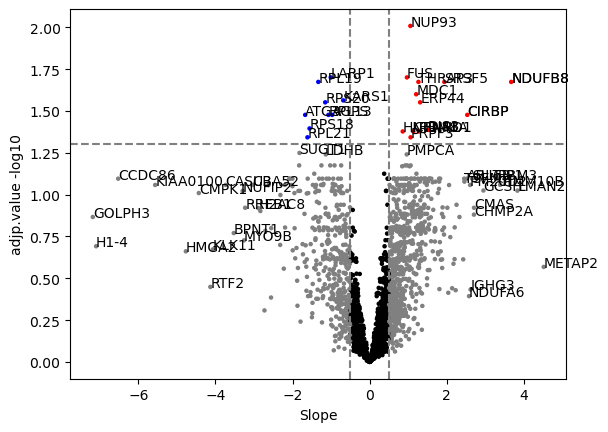

In [117]:
# Plot all the protein from their slope value
## Plot, after convertion  y to log10(pvalue)
top_pvalue = df_linregress.sort_values(by='adj_pvalue', ascending=True).head(25)
top_neg_slope = df_linregress.sort_values(by='slope', ascending=True).head(15)
top_pos_slope = df_linregress.sort_values(by='slope', ascending=False).head(15)

print(len(df_linregress), '\n')
plt.scatter(x=df_linregress['slope'], 
            y=df_linregress['adj_pvalue'].apply(lambda x:-numpy.log10(x)),
            s=5,
            c = colors)
plt.xlabel("Slope")
plt.ylabel("adjp.value -log10")

# Annotate points on the plot with Symbol names
for index, row in top_pvalue.iterrows():
    plt.annotate(row['Gene'], (row['slope'], -numpy.log10(row['adj_pvalue'])),
                fontsize = 10)
    
for index, row in top_neg_slope.iterrows():
    plt.annotate(row['Gene'], (row['slope'], -numpy.log10(row['adj_pvalue'])),
                fontsize = 10)
    
for index, row in top_pos_slope.iterrows():
    plt.annotate(row['Gene'], (row['slope'], -numpy.log10(row['adj_pvalue'])),
                fontsize = 10)
    
# pvalue <0.05
plt.axhline(-numpy.log10(0.05),color="grey",linestyle="--")
plt.axvline(-0.5,color="grey",linestyle="--")
plt.axvline(0.5,color="grey",linestyle="--")
plt.show()
# title_file = 'volcano_proteomic_slope'
# plt.savefig(file_directory+'3) output/Proteomics/'+'volcano_slope_proteomics_adjpval'+'.svg')

In [118]:
#define the colors
colors = ['coral' if x < 2 and y > 0.6
          else 'dodgerblue' if x > -2 and y < -0.6
          else 'red' if  x > 2 and y > 0.6
          else 'blue' if x < -2 and y < -0.6
          else 'grey' if (-0.6 < y < 0.6) and (-2 < x < 2)
          else 'black' for x, y in zip(df_linregress['slope'], 
                                      df_linregress['rvalue'])]

blue_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'blue']
red_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'red']
dodgerblue_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'dodgerblue']
coral_indices = [gene for gene, color in zip(df_linregress['Gene'], colors) if color == 'coral']

blue_genes_n = len(set(blue_indices))
red_genes_n = len(set(red_indices))
dodgerblue_genes_n = len(set(dodgerblue_indices))
coral_genes_n = len(set(coral_indices))

302


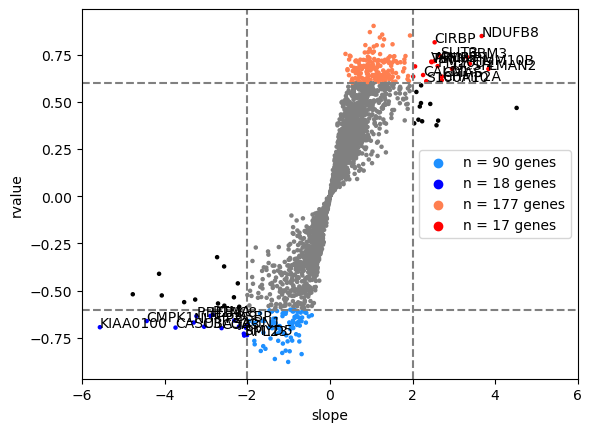

In [119]:
# Plot all the protein from their slope value
df_linregress_high_Rval = df_linregress[df_linregress['Gene'].isin(high_Rvalue_linregress_proteins)]
print(len(df_linregress_high_Rval))

top_neg_slope = df_linregress_high_Rval.sort_values(by='slope', ascending=True).head(15)
top_pos_slope = df_linregress_high_Rval.sort_values(by='slope', ascending=False).head(15)


plt.scatter(x=df_linregress['slope'], 
            y=df_linregress['rvalue'],s=5,
            c= colors)

plt.scatter(x=[],y=[], marker="o", color='dodgerblue', label= f'n = {dodgerblue_genes_n} genes')
plt.scatter(x=[],y=[], marker="o", color='blue', label= f'n = {blue_genes_n} genes')
plt.scatter(x=[],y=[], marker="o", color='coral', label= f'n = {coral_genes_n} genes')
plt.scatter(x=[],y=[], marker="o", color='red', label= f'n = {red_genes_n} genes')


plt.xlabel("slope")
plt.ylabel("rvalue")
plt.legend()
plt.xlim(-6,6)

# Annotate points on the plot with Symbol names
for index, row in top_neg_slope.iterrows():
    plt.annotate(row['Gene'], (row['slope'], row['rvalue']),
                fontsize = 10)
    
for index, row in top_pos_slope.iterrows():
    plt.annotate(row['Gene'], (row['slope'], row['rvalue']),
                fontsize = 10)
    
plt.axhline((0.6),color="grey",linestyle="--")
plt.axhline((-0.6),color="grey",linestyle="--")
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")

# plt.savefig(file_directory+'3) output/Proteomics/'+'volcano_rvalue_slope_proteomics'+'.svg')

## Check if our known targets are well affected at 32°C

In [121]:
df_with_tripl[df_with_tripl.index == 'RING1']

,Ctrl,Ctrl,Ctrl,3h,3h,3h,6h,6h,6h,9h,9h,9h,12h,12h,12h,16h,16h,16h
Gene,,,,,,,,,,,,,,,,,,
RING1,93.5,100.5,88.3,84.1,85.6,99.9,98.1,90.4,93.6,110.5,105.7,109.4,103.2,107.2,109.7,104.2,112.4,103.8


    Gene conditions  value
0  RING1       Ctrl   93.5
1  SMYD5       Ctrl  101.6
2  RING1       Ctrl  100.5
3  SMYD5       Ctrl  100.2
4  RING1       Ctrl   88.3 



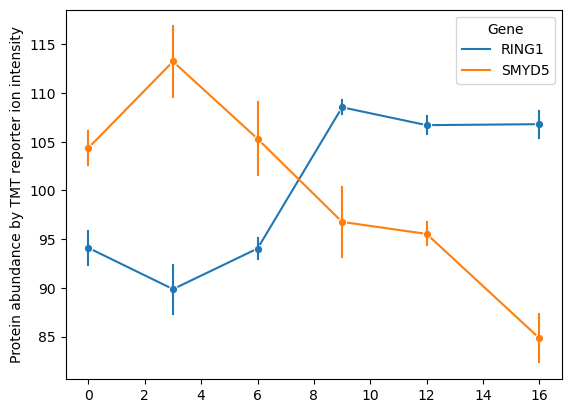

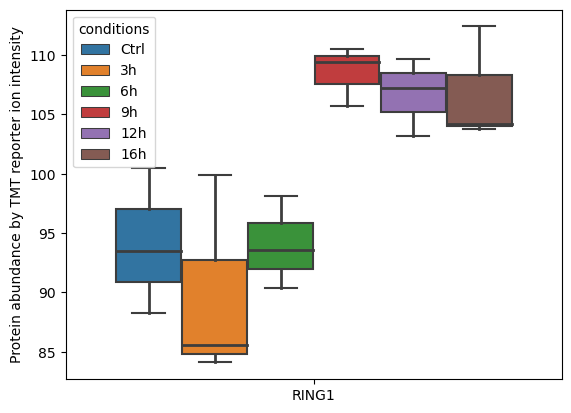

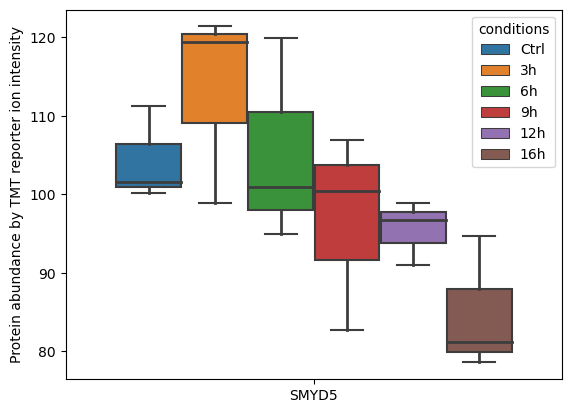

In [162]:
# Select the targets
df_targets =  df_with_tripl[ (df_with_tripl.index == 'RING1') | (df_with_tripl.index == 'SMYD5')]

# From Wide to Long table
df_targets = df_targets.reset_index()
df_targets = df_targets.melt(id_vars=["Gene"], var_name="conditions")

## pull the technical triplicate
df_targets['conditions'] = df_targets['conditions'].str.split('_').str[0]
print(f'{df_targets.head()} \n')

# Print linregess results for the targets
df_targets2 = df_targets.copy()
df_targets2['conditions'].replace({'Ctrl': 0, '3h': 3, '6h': 6, 
                                  '9h': 9, '12h': 12, '16h': 16, }, inplace=True)

seaborn.lineplot(data = df_targets2, x='conditions' , y='value', hue= "Gene",
                marker='o',err_style="bars", errorbar=('se', 0.5))

plt.ylabel("Protein abundance by TMT reporter ion intensity")
plt.xlabel("")
plt.show()
plt.close()

# Expression of the target proteins over time
targets = ['RING1', 'SMYD5']

for target in targets:
    df_plt = df_targets[df_targets['Gene'] == target]
    seaborn.boxplot(df_plt, y = 'value', x = 'Gene', hue = 'conditions', 
                medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)
    
    plt.ylabel("Protein abundance by TMT reporter ion intensity")
    plt.xlabel("")
    plt.show()
    plt.close()

    Gene conditions  value
0  CIRBP       Ctrl   79.2
1   RBM3       Ctrl   80.3
2  SMYD5       Ctrl  101.6
3  CIRBP       Ctrl  101.4
4   RBM3       Ctrl   90.6 



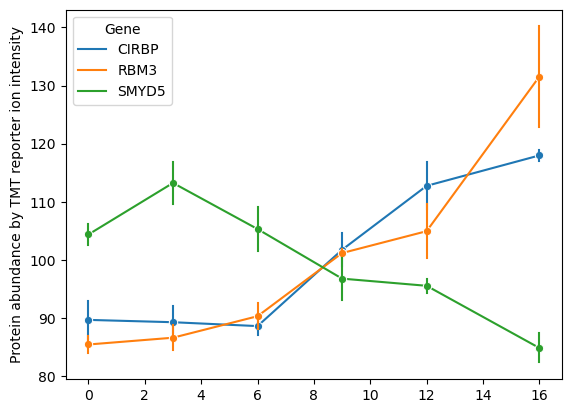

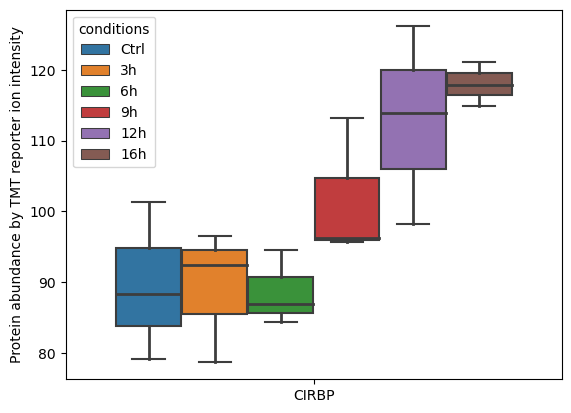

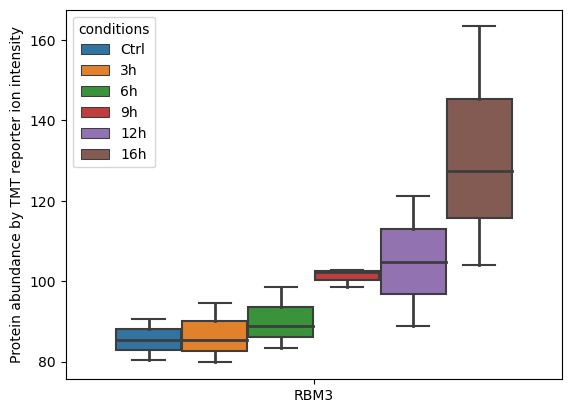

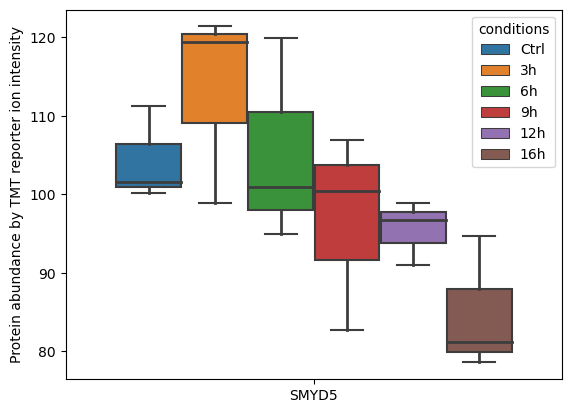

In [163]:
# Select the targets
df_targets =  df_with_tripl[ (df_with_tripl.index == 'CIRBP') 
                            | (df_with_tripl.index == 'RBM3') | (df_with_tripl.index == 'SMYD5')]

# From Wide to Long table
df_targets = df_targets.reset_index()
df_targets = df_targets.melt(id_vars=["Gene"], var_name="conditions")

## pull the technical triplicate
df_targets['conditions'] = df_targets['conditions'].str.split('_').str[0]
print(f'{df_targets.head()} \n')

# Print linregess results for the targets
df_targets2 = df_targets.copy()
df_targets2['conditions'].replace({'Ctrl': 0, '3h': 3, '6h': 6, 
                                  '9h': 9, '12h': 12, '16h': 16, }, inplace=True)

seaborn.lineplot(data = df_targets2, x='conditions' , y='value', hue= "Gene",
                marker='o',err_style="bars", errorbar=('se', 0.5))

plt.ylabel("Protein abundance by TMT reporter ion intensity")
plt.xlabel("")
plt.show()
plt.close()

# Expression of the target proteins over time
targets = ['CIRBP', 'RBM3', 'SMYD5']

for target in targets:
    df_plt = df_targets[df_targets['Gene'] == target]
    seaborn.boxplot(df_plt, y = 'value', x = 'Gene', hue = 'conditions', 
                medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)
    
    plt.ylabel("Protein abundance by TMT reporter ion intensity")
    plt.xlabel("")
    plt.show()
    plt.close()

    Gene conditions  value
0  SMYD5       Ctrl  101.6
1   RPL6       Ctrl   98.3
2  SUMO1       Ctrl  102.8
3  SUMO2       Ctrl   88.2
4  SMYD5       Ctrl  100.2 



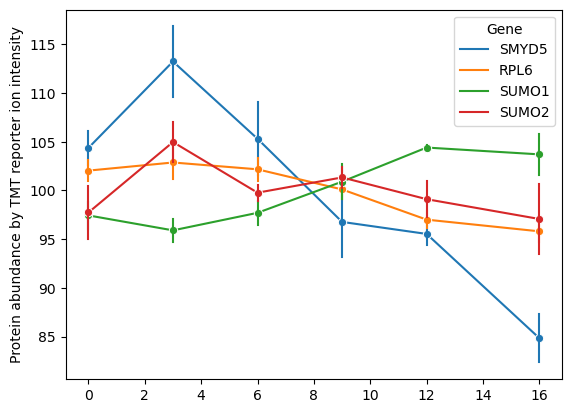

In [167]:
# Select the targets
df_targets =  df_with_tripl[ (df_with_tripl.index == 'SMYD5') 
                            | (df_with_tripl.index == 'SUMO1') 
                            | (df_with_tripl.index == 'SUMO2')
                            | (df_with_tripl.index == 'RPL6') ]

# From Wide to Long table
df_targets = df_targets.reset_index()
df_targets = df_targets.melt(id_vars=["Gene"], var_name="conditions")

## pull the technical triplicate
df_targets['conditions'] = df_targets['conditions'].str.split('_').str[0]
print(f'{df_targets.head()} \n')

# Print linregess results for the targets
df_targets2 = df_targets.copy()
df_targets2['conditions'].replace({'Ctrl': 0, '3h': 3, '6h': 6, 
                                  '9h': 9, '12h': 12, '16h': 16, }, inplace=True)

seaborn.lineplot(data = df_targets2, x='conditions' , y='value', hue= "Gene",
                marker='o',err_style="bars", errorbar=('se', 0.5))

plt.ylabel("Protein abundance by TMT reporter ion intensity")
plt.xlabel("")
plt.show()
plt.close()

## Overlap with RNAseq

The overlapping targets are CHORDC1, NOC3L, CIRBP, SRSF5, RBM3 and HNRNPDL

      Gene conditions  value
0    SRSF5       Ctrl   87.4
1  CHORDC1       Ctrl   99.4
2    NOC3L       Ctrl  121.4
3  HNRNPDL       Ctrl  100.8
4    SRSF5       Ctrl   99.4 



C:\Users\kja11\AppData\Local\Temp\ipykernel_9028\1241715391.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_targets2['conditions'].replace({'Ctrl': 0, '3h': 3, '6h': 6,
C:\Users\kja11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kja11\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_i

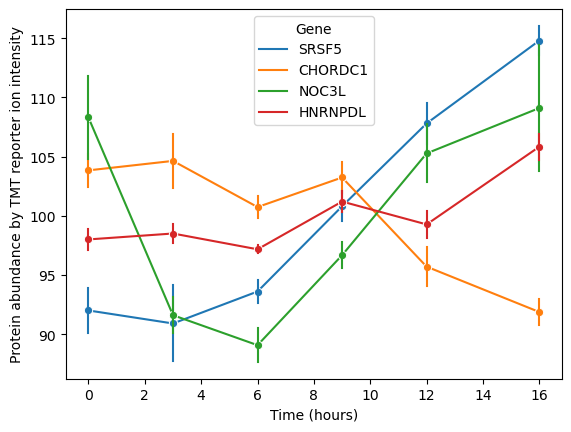

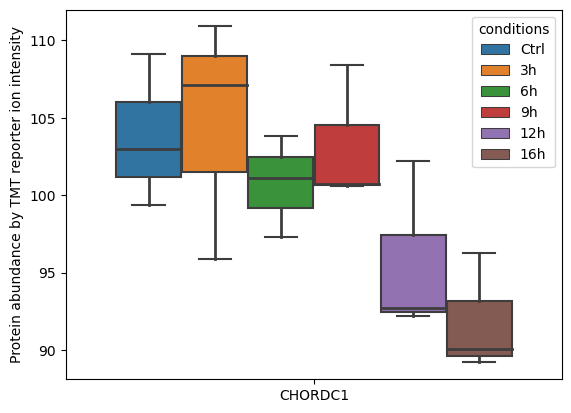

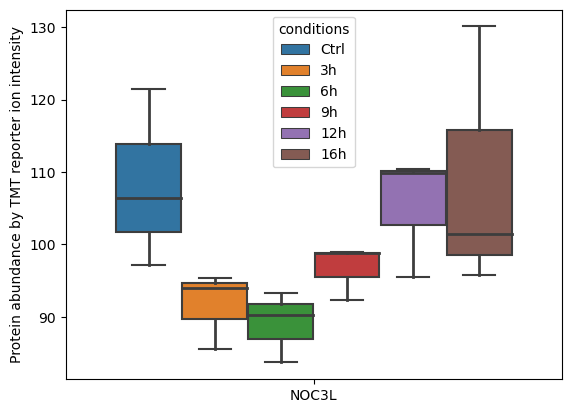

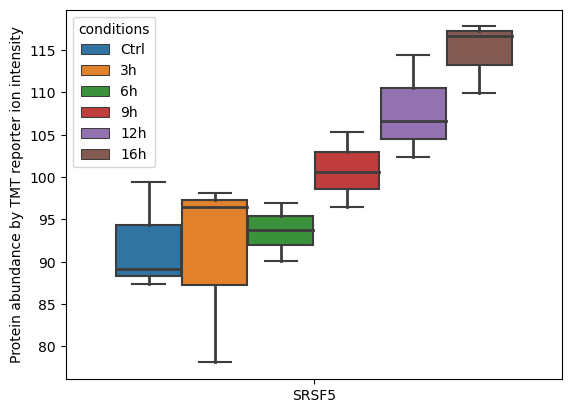

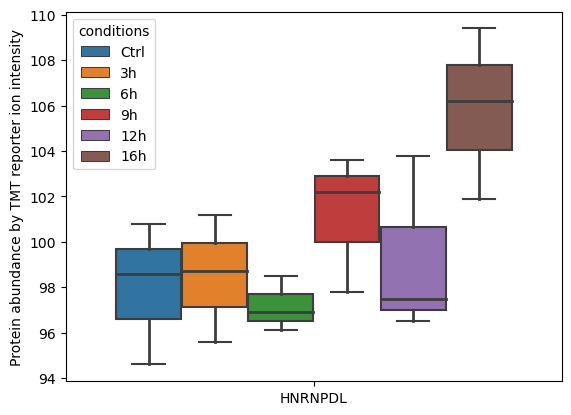

In [130]:
# Select the targets
df_targets =  df_with_tripl[ (df_with_tripl.index == 'CHORDC1') 
                            | (df_with_tripl.index == 'NOC3L') 
                            | (df_with_tripl.index == 'SRSF5')
                            | (df_with_tripl.index == 'HNRNPDL') ]

# From Wide to Long table
df_targets = df_targets.reset_index()
df_targets = df_targets.melt(id_vars=["Gene"], var_name="conditions")

## pull the technical triplicate
df_targets['conditions'] = df_targets['conditions'].str.split('_').str[0]
print(f'{df_targets.head()} \n')

# Print linregess results for the targets
df_targets2 = df_targets.copy()
df_targets2['conditions'].replace({'Ctrl': 0, '3h': 3, '6h': 6, 
                                  '9h': 9, '12h': 12, '16h': 16, }, inplace=True)

seaborn.lineplot(data = df_targets2, x='conditions' , y='value', hue= "Gene",
                marker='o',err_style="bars", errorbar=('se', 0.5))

plt.ylabel("Protein abundance by TMT reporter ion intensity")
plt.xlabel("Time (hours)")
plt.show()
plt.close()

# Expression of the target proteins over time
targets = ['CHORDC1', 'NOC3L', 'SRSF5', 'HNRNPDL']

for target in targets:
    df_plt = df_targets[df_targets['Gene'] == target]
    seaborn.boxplot(df_plt, y = 'value', x = 'Gene', hue = 'conditions', 
                medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)
    
    plt.ylabel("Protein abundance by TMT reporter ion intensity")
    plt.xlabel("")
    plt.show()
    plt.close()

## Heatmap from expression

### Heatmap of proteins with rvalue > 0.6 (abs)

In [131]:
# Count number of cells in specific interval to select heatmap vmin/vmax
df_high_Rval = df_zscore[df_zscore.index.isin(high_Rvalue_linregress_proteins)]
print(len(df_high_Rval), df_high_Rval.min().min(), df_high_Rval.max().max(), '\n')

values = df_high_Rval.values.flatten()
bin_edges = numpy.arange(-6, 7, 1) 
hist, edges = numpy.histogram(values, bins=bin_edges)

## Create a DataFrame for better visualization
bin_intervals = [f"{edges[i]} to {edges[i+1]}" for i in range(len(edges)-1)]
count_df = pandas.DataFrame({'Interval': bin_intervals, 'Count': hist})
print(count_df)

302 -5.859000276900139 9.375776524693448 

    Interval  Count
0   -6 to -5      1
1   -5 to -4      9
2   -4 to -3     12
3   -3 to -2     54
4   -2 to -1    217
5    -1 to 0    666
6     0 to 1    571
7     1 to 2    209
8     2 to 3     49
9     3 to 4     12
10    4 to 5      3
11    5 to 6      3


number of proteins: 302


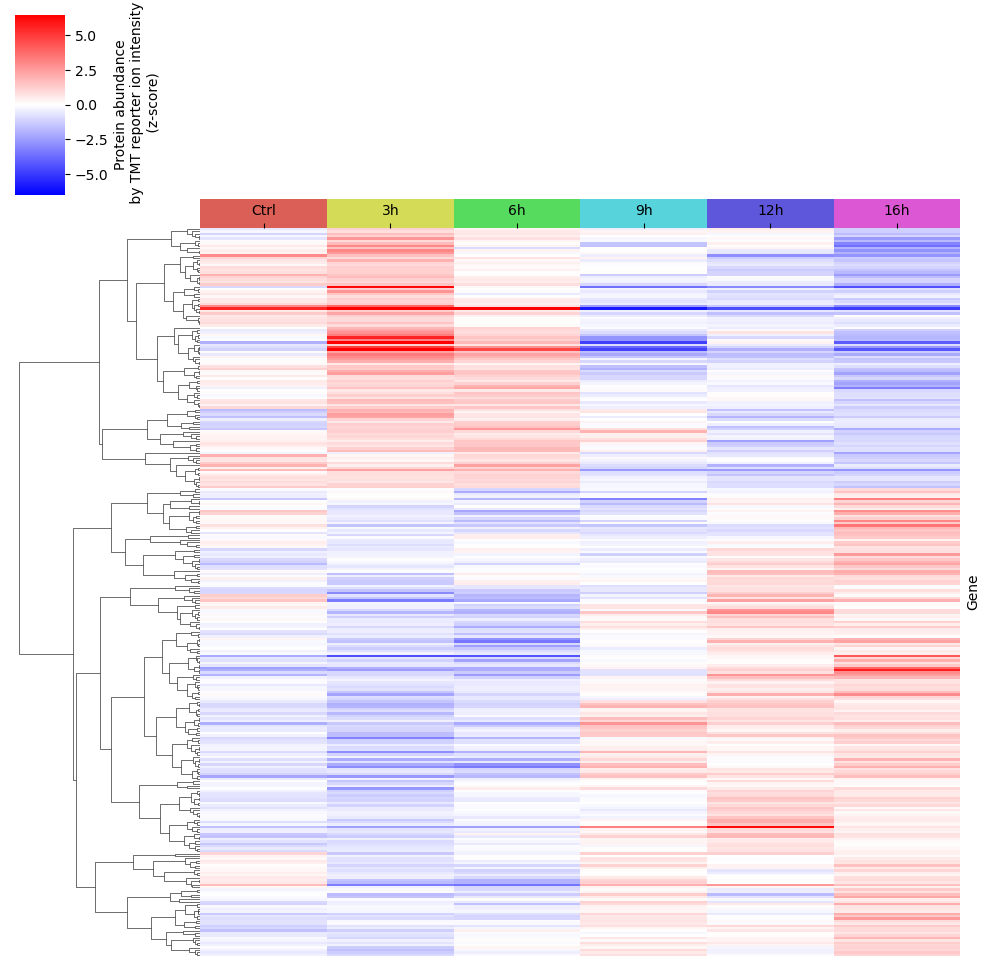

In [132]:
# Heatmap of proteins with rvalue > 0.6
## define the colors, one color per condition 
lut = dict(zip(df_high_Rval.columns.unique(),
               seaborn.hls_palette(6) ))

col_colors_conditions = df_high_Rval.columns.map(lut)

## plot heatmap
print('number of proteins:', len(df_high_Rval))
g =  seaborn.clustermap(df_high_Rval, 
                        cmap='bwr', 
                        row_cluster=True, 
                        col_cluster=False, 
                        vmin=-6.5, vmax=6.5,
                        col_colors = col_colors_conditions,
                        cbar_kws={'label':'Protein abundance\n by TMT reporter ion intensity\n (z-score)'},
                        xticklabels=True, yticklabels=False, 
                        method='complete', metric='cosine')

g.ax_heatmap.xaxis.set_ticks_position('top')
g.ax_heatmap.xaxis.set_label_position('top')


### Select the Overtime Downregulated and Upregulated proteins

In [133]:
sample_names = df_high_Rval.index
num_samples = len(sample_names)

reordered_indices = g.dendrogram_row.reordered_ind #the index in the heatmap
linkage_matrix  = g.dendrogram_row.linkage #the matrix for heatmap
num_clusters = 2 # cluster expected

#Get the cluster labels for each sample
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
print(cluster_labels[:10])

groupDown_samples = [sample_names[i] for i in range(len(sample_names)) if cluster_labels[i] == 1]
groupUp_samples = [sample_names[i] for i in range(len(sample_names)) if cluster_labels[i] == 2]
print(groupUp_samples[:10])

print(f'\nn = {len(groupDown_samples)} down regulated overtime.\nn= {len(groupUp_samples)} up regulated overtime')

[2 1 1 2 1 1 2 2 2 2]
['DIS3', 'NUP93', 'NDUFB8', 'CTNND1', 'PLP2', 'SMC3', 'ILVBL', 'PPIL1', 'RING1', 'APPL1']

n = 108 down regulated overtime.
n= 194 up regulated overtime


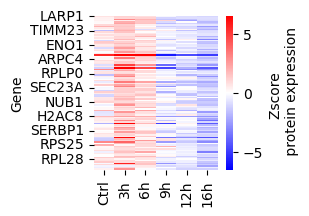

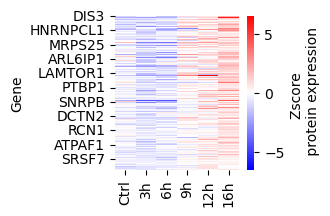

In [134]:
# See if the selection is good
for subgroup in groupDown_samples, groupUp_samples:
    plt.subplots(figsize=(2, 2))
    
    seaborn.heatmap(df_high_Rval[df_high_Rval.index.isin(subgroup)],
                    annot=False, cmap="bwr", 
                    linewidths=0, center=0, vmin=-6.5, vmax=6.5,
                    cbar_kws={'label': 'Zscore \n protein expression'})
    plt.show()

## EnrichR

In [135]:
import warnings
# Filter out the specific warning
warnings.filterwarnings("ignore", message="The 'method' keyword in Series.replace is deprecated")
warnings.filterwarnings("ignore", message="A value is trying to be set on a copy")

In [136]:
# names = gseapy.get_library_name(organism='Human')
# names

### Overtime Down regulated proteins

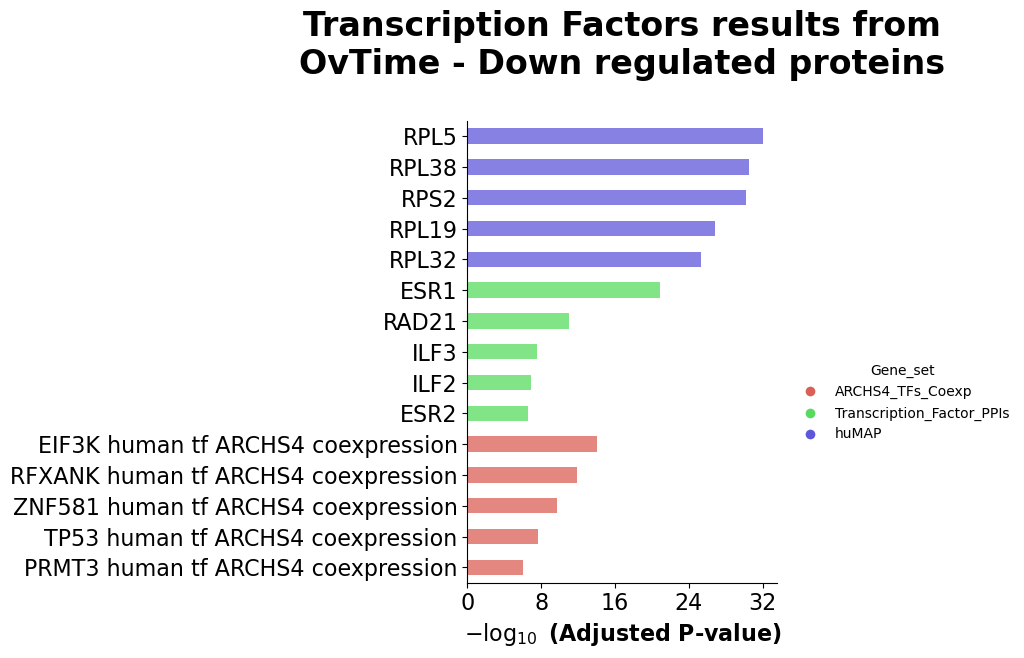

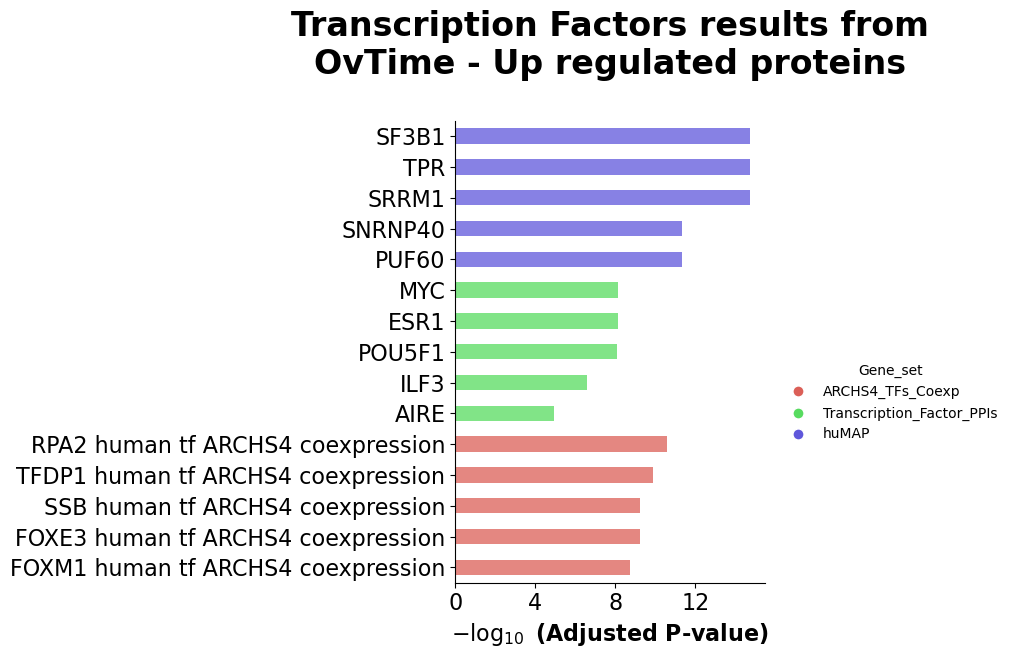

In [137]:
# Perform GO enrichment analysis using Enrichr
subgroups = groupDown_samples, groupUp_samples
sub_labels ='OvTime - Down regulated', 'OvTime - Up regulated'

for i in range(len(subgroups)):
    subgroup = subgroups[i]
    sub_label = sub_labels[i]
    
    enr_TF = gseapy.enrichr(gene_list = subgroup,
                            gene_sets= ['ARCHS4_TFs_Coexp',
                                        'Transcription_Factor_PPIs',
                                        'huMAP'],
                            organism='Human',
                            outdir='Enrichr_results',
                            cutoff=0.05)

    # categorical scatterplot
    colors = seaborn.hls_palette(3)
    barplot(enr_TF.results,
            column="Adjusted P-value",
            group='Gene_set',
            size=10,
            top_term=5,
    #         figsize=(3,5),
            title=f'Transcription Factors results from\n{sub_label} proteins\n',
            color=colors)
    del enr_TF

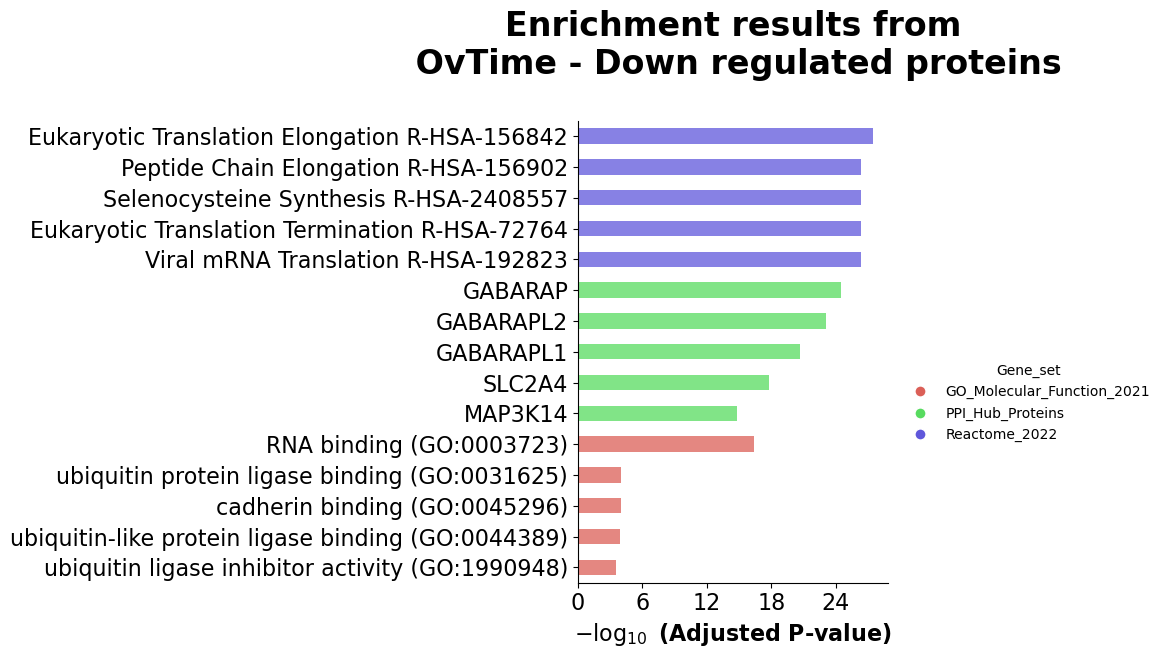

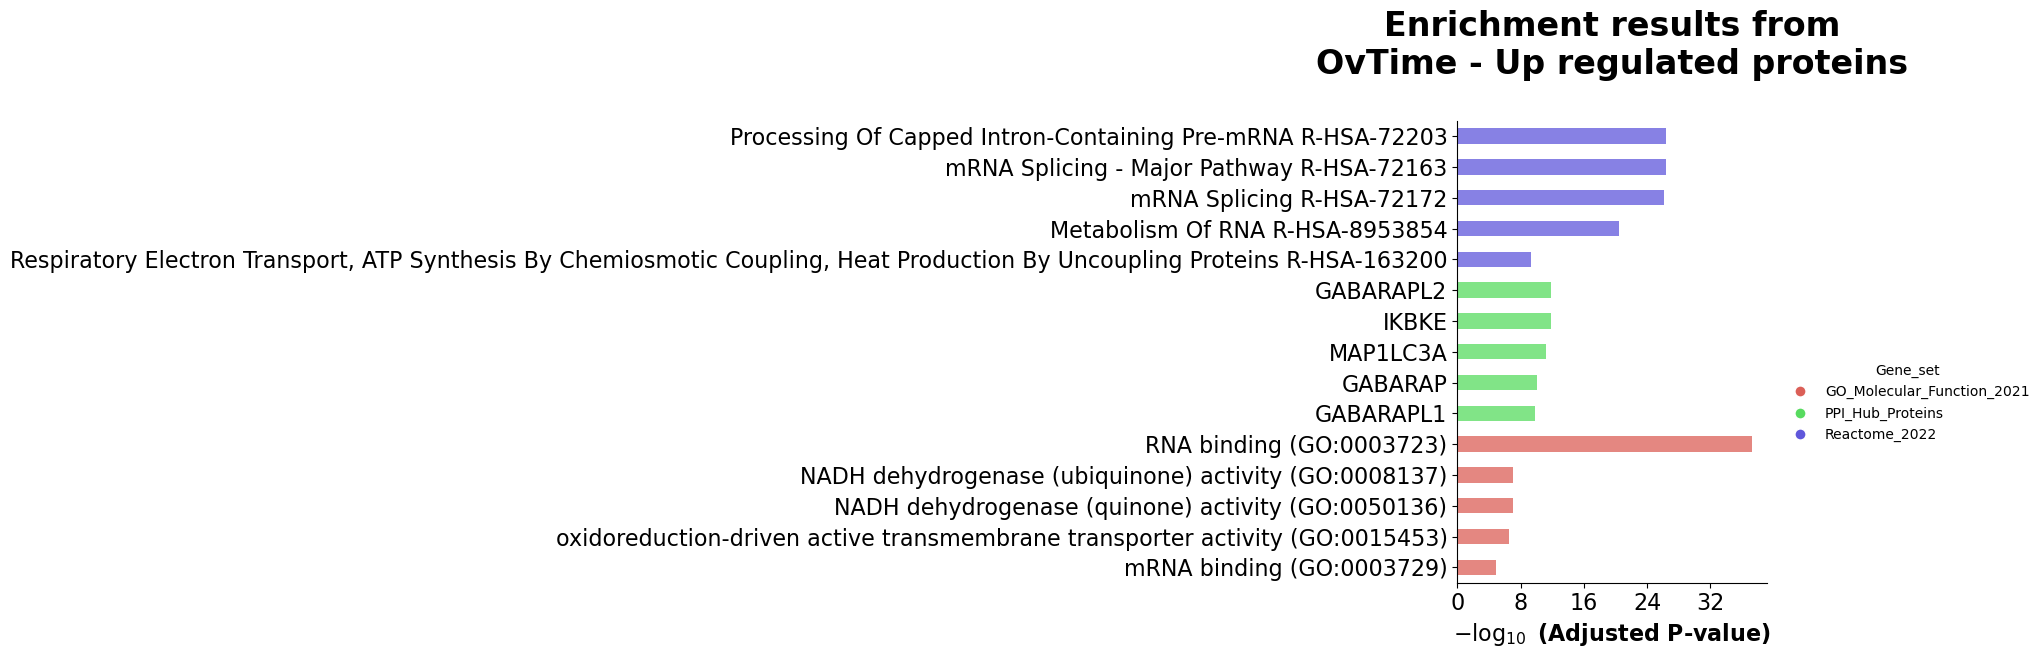

In [138]:
# Perform GO enrichment analysis using Enrichr
subgroups = groupDown_samples, groupUp_samples
sub_labels =' OvTime - Down regulated', 'OvTime - Up regulated'

for i in range(len(subgroups)):
    subgroup = subgroups[i]
    sub_label = sub_labels[i]
    
    enr = gseapy.enrichr(gene_list = subgroup,
                         gene_sets= ['GO_Molecular_Function_2021',
                                     'PPI_Hub_Proteins',
                                     'Reactome_2022'],
                         organism='Human',
                         outdir='Enrichr_results',
                         cutoff=0.05)

     # categorical scatterplot
    colors = seaborn.hls_palette(3)
    barplot(enr.results,
            column="Adjusted P-value",
            group='Gene_set', # set group, so you could do a multi-sample/library comparsion
    #         size=30,
            top_term=5,
            color=colors,
            title=f'Enrichment results from\n{sub_label} proteins\n',)

## GSEA

In [139]:
# Tag % = % of gene hits before (for positive ES) or after (for negative ES) the peak
#         in the running enrichment score. This gives an indication of the percentage 
#         of genes contributing to the enrichment score.

# lead_genes: leading edge genes (gene hits before running enrichment peak)

In [140]:
df_linregress.head(3)

,Gene,slope,intercept,rvalue,pvalue,adj_pvalue
0,DIS3,1.515694,87.275616,0.805491,0.000290,0.040984
1,LARP1,-1.009533,108.867704,-0.877613,0.000017,0.019899
2,ACTB,-0.490661,104.354086,-0.435866,0.104359,0.316498


In [141]:
# Rank and so GSEA plot will be based on SLope . More stat is high more it's diff expressed.
ranking = df_linregress[['Gene', 'slope']].dropna().sort_values('slope', ascending = False)
print(ranking.shape)

(2405, 2)


In [142]:
# # default: Human
# names = gseapy.get_library_name(organism='Human')
# names

### KEGG

2024-09-04 12:37:27,429 [WARNING] Duplicated values found in preranked stats: 0.50% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


positive: 



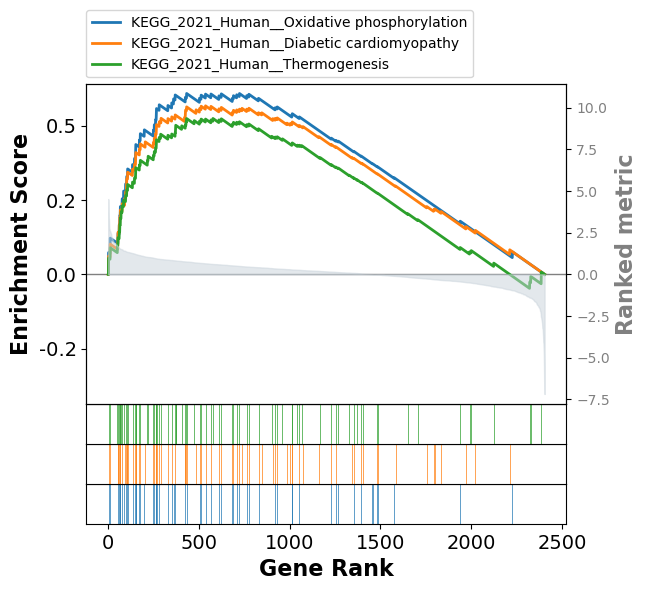

negative: 
                                    Term   Tag %  Gene %
0  KEGG_2021_Human__Coronavirus disease   62/84  20.00%
1             KEGG_2021_Human__Ribosome  62/104  20.00%


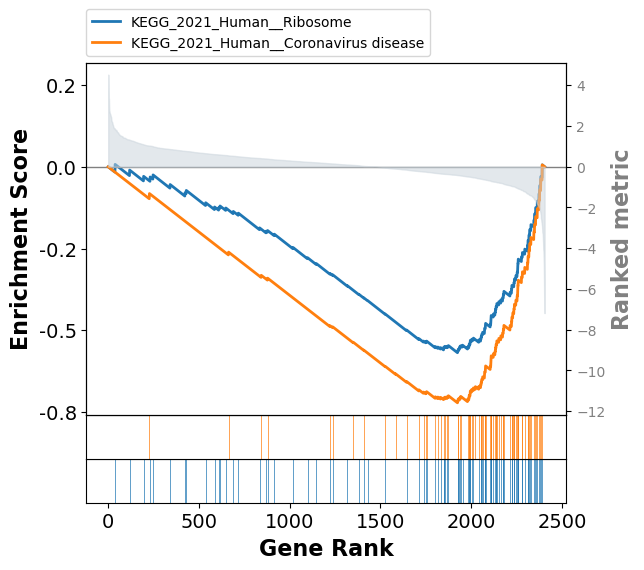

In [155]:
# KEGG_2021_Human
pre_res = gseapy.prerank(rnk = ranking.set_index("Gene", drop=True),
                     gene_sets = ['KEGG_2021_Human'],
                     seed = 6, permutation_num = 100)

enrich_results = pre_res.res2d.sort_values("NES", ascending = False)
terms = enrich_results.Term

# positive
print('positive: \n')
pre_res.plot(terms=terms[:3])
plt.show()
plt.close()

# negative
print('negative: \n', pre_res.res2d.iloc[:2,[1,7,8]])
pre_res.plot(terms=terms[-2:])
plt.show()
plt.close()

In [144]:
lead_genes_Thermo = pre_res.res2d.loc[pre_res.res2d["Term"].str.contains('Thermo')].Lead_genes
lead_genes_Thermo = lead_genes_Thermo.str.split(';')
thermo_prot = lead_genes_Thermo.explode()
print(len(thermo_prot))

thermo_prot[:20]

43


4     NDUFB8
4     NDUFA6
4     ACTL6A
4     NDUFS8
4    NDUFA10
4     NDUFA8
4    ATP5F1D
4    SMARCD2
4     NDUFA2
4     ATP5MF
4    NDUFAB1
4     NDUFB9
4     NDUFS5
4     NDUFS6
4       SDHA
4     COX6B1
4     COX6A1
4       SDHB
4     NDUFB5
4    NDUFAF4
Name: Lead_genes, dtype: object

### Cellular Component

2024-09-04 12:34:15,192 [WARNING] Duplicated values found in preranked stats: 0.50% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


positive: 
                                                 Term  Tag %  Gene %
0  GO_Cellular_Component_2023__Ribosome (GO:0005840)  35/49  17.71%
1  GO_Cellular_Component_2023__Cytosolic Large Ri...  35/42  19.54%
2  GO_Cellular_Component_2023__Large Ribosomal Su...  35/42  19.54%


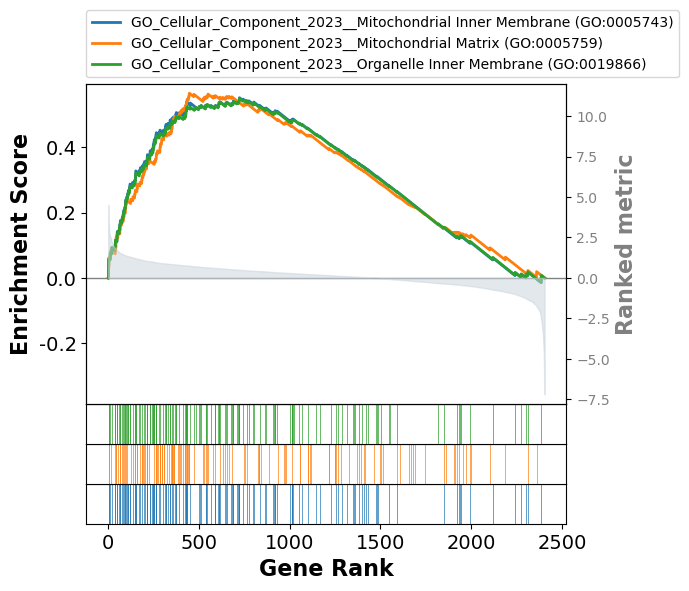

negative: 
 Term      GO_Cellular_Component_2023__P-body (GO:0000932)
Tag %                                                7/27
Gene %                                             31.27%
Name: 99, dtype: object


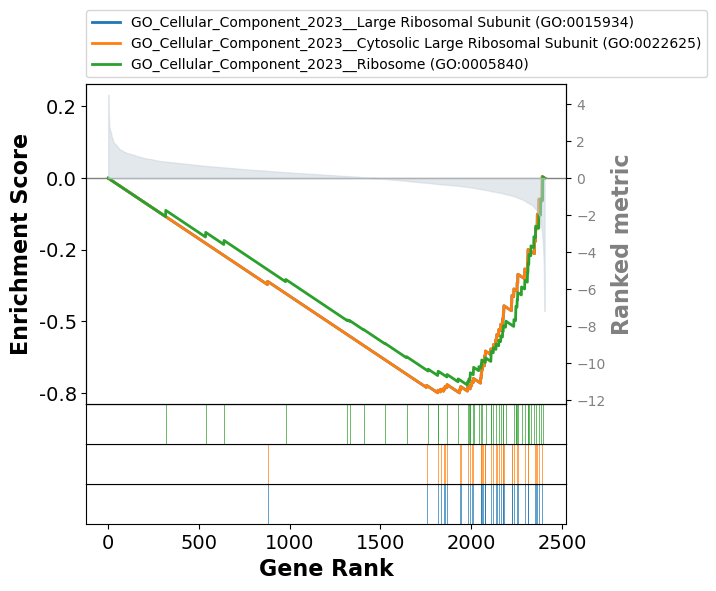

In [145]:
# GO_cellular component_2023
pre_res = gseapy.prerank(rnk = ranking.set_index("Gene", drop=True),
                     gene_sets = ['GO_Cellular_Component_2023'],
                     seed = 6, permutation_num = 100)

enrich_results = pre_res.res2d.sort_values("NES", ascending = False)
terms = enrich_results.Term

# positive
print('positive: \n', pre_res.res2d.iloc[:3,[1,7,8]])
pre_res.plot(terms=terms[:3])
plt.show()
plt.close()


# negative
print('negative: \n', pre_res.res2d.iloc[-1,[1,7,8]])
pre_res.plot(terms=terms[-3:])
plt.show()
plt.close()

### Molecular function

2024-09-04 12:34:17,150 [WARNING] Duplicated values found in preranked stats: 0.50% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


positive: 
                                                 Term  Tag %  Gene %
0  GO_Molecular_Function_2023__NADH Dehydrogenase...  15/25  17.71%
1  GO_Molecular_Function_2023__NADH Dehydrogenase...  15/25  17.71%
2  GO_Molecular_Function_2023__Oxidoreduction-Dri...  18/33  22.33%


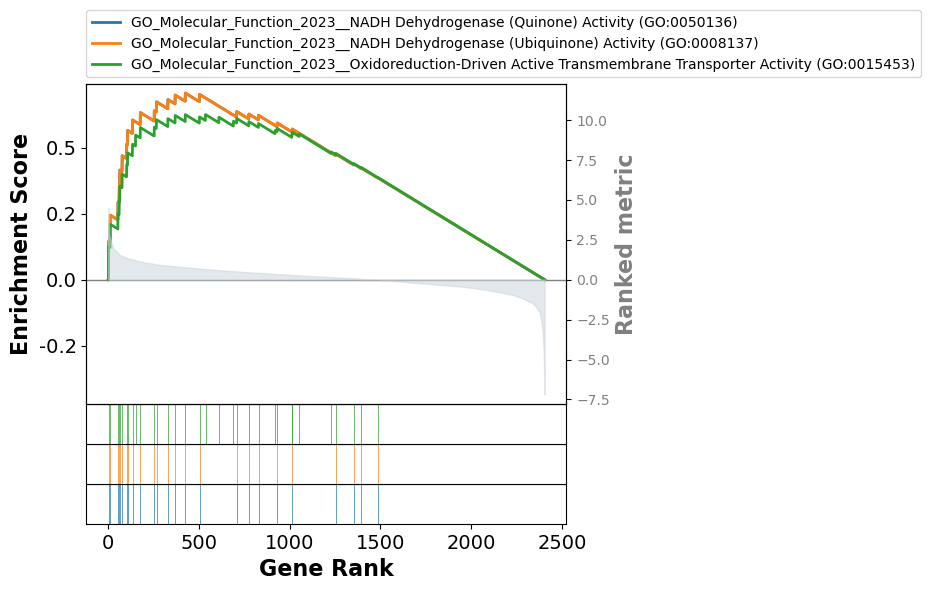

nothing interesting in negative


In [146]:
# GO_Molecular_Function_2023
pre_res = gseapy.prerank(rnk = ranking.set_index("Gene", drop=True),
                     gene_sets = ['GO_Molecular_Function_2023'],
                     seed = 6, permutation_num = 100)

enrich_results = pre_res.res2d.sort_values("NES", ascending = False)
terms = enrich_results.Term

# positive
print('positive: \n', pre_res.res2d.iloc[:3,[1,7,8]])

pre_res.plot(terms=terms[:3])
plt.show()
plt.close()

# negative
print('nothing interesting in negative')

### Biological Process

2024-09-04 12:34:18,040 [WARNING] Duplicated values found in preranked stats: 0.50% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


positive: 
                                                 Term  Tag %  Gene %
0  GO_Biological_Process_2023__Cytoplasmic Transl...  58/83  20.00%
1  GO_Biological_Process_2023__Proton Motive Forc...  25/39  21.33%
2  GO_Biological_Process_2023__Proton Motive Forc...  26/40  21.33%


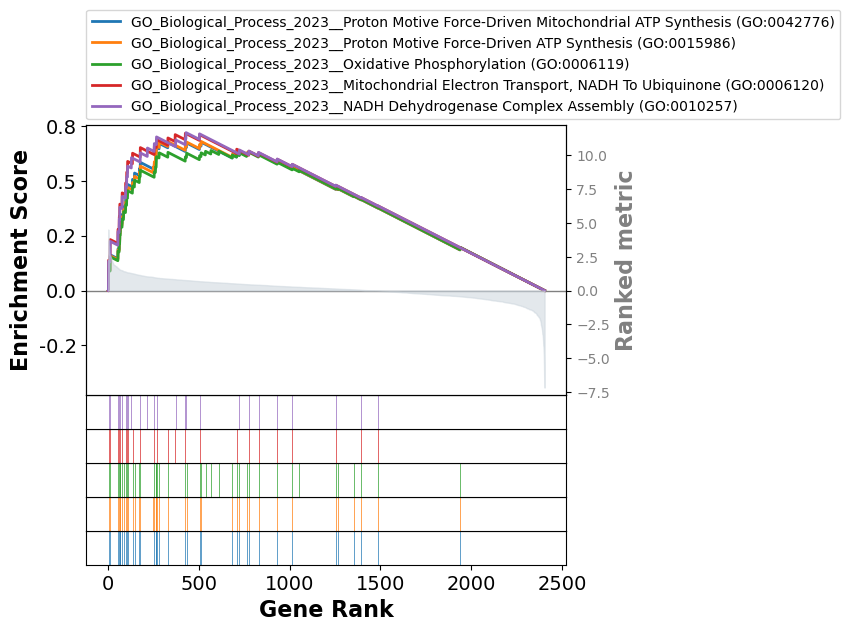

negative: 
                                                   Term  Tag %  Gene %
425  GO_Biological_Process_2023__Proteasomal Protei...  27/60  48.11%


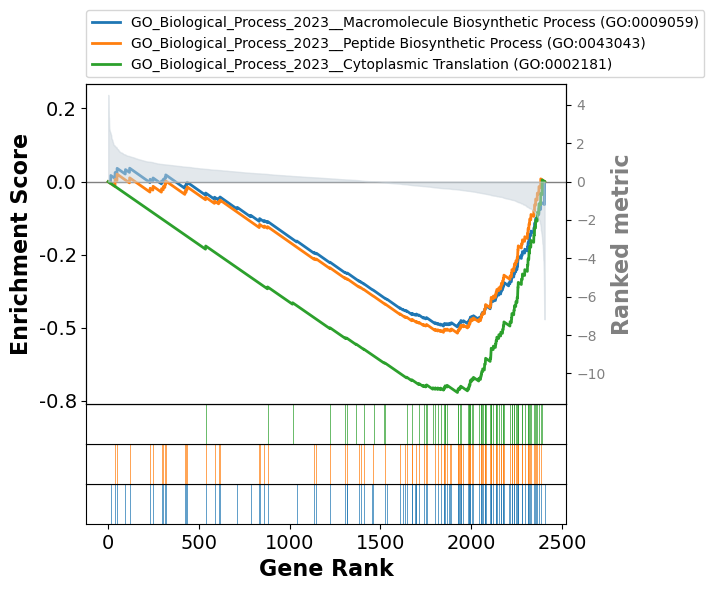

In [147]:
# GO_Biological_Process_2023
pre_res = gseapy.prerank(rnk = ranking.set_index("Gene", drop=True),
                     gene_sets = ['GO_Biological_Process_2023'],
                     seed = 6, permutation_num = 100)

enrich_results = pre_res.res2d.sort_values("NES", ascending = False)
terms = enrich_results.Term

# positive
print('positive: \n', pre_res.res2d.iloc[:3,[1,7,8]])
pre_res.plot(terms=terms[:5])
plt.show()
plt.close()

# negative
print('negative: \n', pre_res.res2d.iloc[-1:,[1,7,8]])
pre_res.plot(terms=terms[-3:])
plt.show()
plt.close()

In [148]:
GO_Biol_term = enrich_results.Term
GO_Biol_term[GO_Biol_term.str.contains('ubi')]

407    GO_Biological_Process_2023__Protein Polyubiqui...
290    GO_Biological_Process_2023__Protein Deubiquiti...
Name: Term, dtype: object

#### Ubiquitin

2024-09-04 12:34:20,395 [WARNING] Duplicated values found in preranked stats: 0.50% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


positive: 
                                                 Term  Tag %  Gene %
0  GO_Biological_Process_2023__Cytoplasmic Transl...  58/83  20.00%
1  GO_Biological_Process_2023__Proton Motive Forc...  25/39  21.33%
2  GO_Biological_Process_2023__Proton Motive Forc...  26/40  21.33%


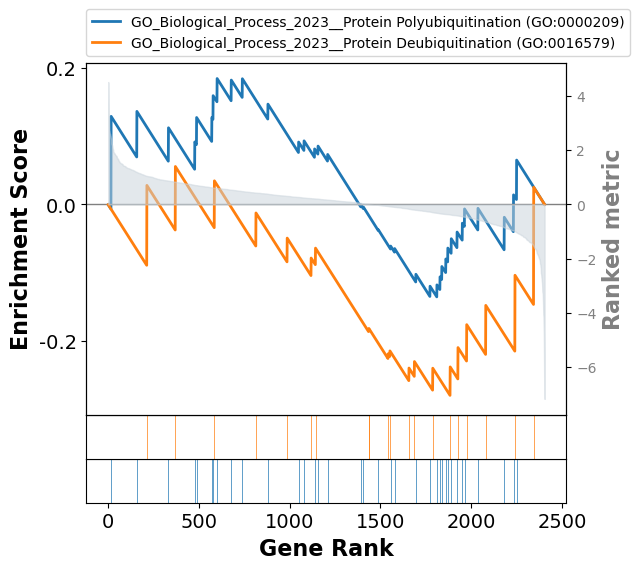

In [149]:
# GO_Biological_Process_2023
pre_res = gseapy.prerank(rnk = ranking.set_index("Gene", drop=True),
                     gene_sets = ['GO_Biological_Process_2023'],
                     seed = 6, permutation_num = 100)

enrich_results = pre_res.res2d.sort_values("NES", ascending = False)
terms = enrich_results.Term
terms = terms[terms.str.contains('ubi')]
# positive
print('positive: \n', pre_res.res2d.iloc[:3,[1,7,8]])
pre_res.plot(terms=terms[:5])
plt.show()
plt.close()